In [5]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../../build')
import libry as lry
import time
import copy

In [6]:
K = lry.Config()
D = K.view()

In [7]:
K.clear()
K.addFile('human.g')

In [8]:
def multiTask(num_steps=1000, alpha=1., sigma=0.01):
    global err_to_midpoint
    err_to_midpoint = []
    y_lhand_target_v = [0, 0, 1]
    y_target = [-0.2, -0.4, 1.1]
    
    # init joint state to zero vector
    q = np.zeros(K.getJointDimension())
    q_home = np.copy(q)
    K.setJointState(q)
    
    # get position and position Jacobian of right hand
    F = K.feature(lry.FS.position, ["|handR"])
    y, J = F.eval(K)
    
        
    F_chest = K.feature(lry.FS.position, ['chest'])
    y_chest, J_chest = F_chest.eval(K)
    
    F_lhand = K.feature(lry.FS.vectorZ, ['|handL'])
    y_lhand, J_lhand = F_lhand.eval(K)
    
    F_eye_p = K.feature(lry.FS.position, ['manhead'])
    y_eye_p, J_eyr_p = F_eye_p.eval(K)
    
    F_eye_v = K.feature(lry.FS.vectorZ, ['manhead'])
    y_eye_v, J_eye_v = F_eye_v.eval(K)
    
    y0 = copy.deepcopy(y)
    y0_chest = copy.deepcopy(y_chest)
    W = np.identity(K.getJointDimension())
    
    for i in range(num_steps):
        Phi = []
        PhiJ = []
        
        # track circle
        yt = y_target + .2 * np.array([np.cos(i/20.), 0, np.sin(i/20.)])
        
        Phi = (yt-y)/sigma
        PhiJ = (J/sigma)

        err_to_midpoint.append(np.linalg.norm(y - y_target))
        
        # 1st task: joint should stay close to zero
        Phi = np.vstack((Phi, 0.25 * (y0_chest - y_chest) / sigma))
        PhiJ = np.vstack((PhiJ, 0.25 * J_chest / sigma))


        # 2nd task: left hand should point upwards
        Phi = np.vstack((Phi, (y_lhand_target_v - y_lhand) / sigma))
        PhiJ = np.vstack((PhiJ, J_lhand / sigma))

        # 3rd task: robot should look at right hand
        Phi = np.vstack((Phi, np.linalg.norm(y - y_eye_p) - y_eye_v))
        PhiJ = np.vstack((PhiJ, J_eye_v / sigma))
        # more "natural" movement
        PhiJ = PhiJ.reshape(4,3,27)
        for p1,p2 in zip(Phi, PhiJ):
            q += 0.1 * np.dot(np.dot(np.linalg.inv(np.dot(np.transpose(p2), p2) + W), np.transpose(p2)), p1)
        
        # q += 0.1 * np.dot(np.dot(np.linalg.inv(np.dot(np.transpose(PhiJ), PhiJ) + W), np.transpose(PhiJ)), Phi)
              
        
        
        K.setJointState(q)
        y, J = F.eval(K)
        y_chest, J_chest = F_chest.eval(K)
        y_lhand, J_lhand = F_lhand.eval(K)
        y_eye_p, J_eye_p = F_eye_p.eval(K)
        y_eye_v, J_eye_v = F_eye_v.eval(K)
        time.sleep(0.04)
    

In [9]:
multiTask()

KeyboardInterrupt: 

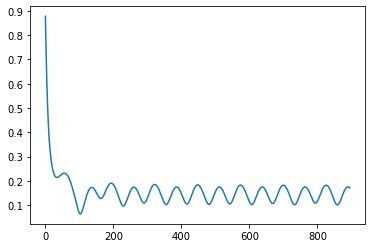

In [10]:
plt.plot(err_to_midpoint)